<a href="https://colab.research.google.com/github/denniesbor/twitter_political_polarization/blob/from_colab/notebooks/broadband.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install contractions
# !pip install tweetnlp

# # Visualize topics in the datasets
# # Choose an embedding backend
# !pip install bertopic["flair", "gensim", "spacy", "use"]

# # Topic modeling with images
# !pip install bertopic["vision"]

# !pip install cohere

# !pip install --upgrade accelerate bitsandbytes xformers adjustText
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 tokenizers==0.13.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.7 MB/s eta 0:00:00


In [ ]:
import re

import contractions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# import cohere

import nltk
from nltk.corpus import stopwords

nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

# import tweetnlp
# from bertopic import BERTopic
import statsmodels.api as sm
from sklearn import preprocessing

tqdm.pandas(desc="My bar!")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# read the data

df = pd.read_csv(
    "/content/drive/MyDrive/summer-2023/raw_data/broadband.csv",
    usecols=["username", "tweet", "cohere"],
)
state_demogr_df = pd.read_csv(
    "/content/drive/MyDrive/summer-2023/raw_data/broadband/processed_data/state_demographic_data.csv"
)
cd_demogr_df = pd.read_csv(
    "/content/drive/MyDrive/summer-2023/raw_data/broadband/processed_data/congressional_district_demographic_data.csv"
)
cd116_congress_bios = pd.read_csv(
    "/content/drive/MyDrive/summer-2023/raw_data/broadband/processed_data/cd116_bio.csv"
)
cd116_senate_bios = pd.read_csv(
    "/content/drive/MyDrive/summer-2023/raw_data/broadband/processed_data/cs116_bio.csv"
)
broadband = pd.read_csv(
    "/content/drive/MyDrive/summer-2023/raw_data/broadband/processed_data/broadband_demand_supply_v2.csv"
)
broadband.rename(columns={"cd116": "district"}, inplace=True)

In [ ]:
cd_demogr_df["population_white_percentage"] = (
    cd_demogr_df["2014_2018_acs_citizen_adult_population_white"]
    / cd_demogr_df[
        [
            "2014_2018_acs_citizen_adult_population_white",
            "2014_2018_acs_citizen_adult_population_black",
            "2014_2018_acs_citizen_adult_population_latino",
            "2014_2018_acs_citizen_adult_population_asian_and_pacific_islander",
            "2014_2018_acs_citizen_adult_population_native",
            "2014_2018_acs_citizen_adult_population_other",
        ]
    ].sum(axis=1)
) * 100

state_demogr_df["population_white_percentage"] = (
    state_demogr_df["2014_2018_acs_citizen_adult_population_white"]
    / state_demogr_df[
        [
            "2014_2018_acs_citizen_adult_population_white",
            "2014_2018_acs_citizen_adult_population_black",
            "2014_2018_acs_citizen_adult_population_latino",
            "2014_2018_acs_citizen_adult_population_asian_and_pacific_islander",
            "2014_2018_acs_citizen_adult_population_native",
            "2014_2018_acs_citizen_adult_population_other",
        ]
    ].sum(axis=1)
) * 100

In [ ]:
df_cd.to_csv("congressional_district_broadband_data.csv", index=False)

## Merging Congressional Districts data

In [ ]:
# combining the congress bios, congressional district demographic data, and broadband demand and supply

df_cd = cd116_congress_bios.merge(cd_demogr_df, on=["state", "district"]).merge(
    broadband, on=["state", "district"]
)
df_cd.reset_index(drop=True, inplace=True)

[
    "party",
    "ideology",
    "ideology_cluster",
    "2014_2018_acs_educational_attainment_among_adults_25+_and_median_household_income_high_school_or_greater",
    "median_income",
    "population_white_percentage",
    "percentage_adv_tech (cd)",
    "cd_urban_pop_ratio",
    "(cd) perc_estimate_households_without_internet",
]

In [ ]:
!pip install black

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00


In [ ]:
[col for col in df_cd.columns if "state" not in col]

['party',
 'first_name',
 'last_name',
 'elected_appointed',
 'birth_year_x',
 'gender',
 'race_ethnicity',
 'religion',
 'lgbtq',
 'pre_election_incumbent',
 'period',
 'military_service',
 'is_vet',
 'district',
 'birthday',
 'type',
 'senate_class',
 'twitter',
 'twitter_id',
 'govtrack_id',
 'birth_year_y',
 'age',
 'ideology',
 'christian',
 'since_first_elected',
 'ideology_cluster',
 '2014_2018_acs_citizen_adult_population_white',
 '2014_2018_acs_citizen_adult_population_black',
 '2014_2018_acs_citizen_adult_population_latino',
 '2014_2018_acs_citizen_adult_population_asian_and_pacific_islander',
 '2014_2018_acs_citizen_adult_population_native',
 '2014_2018_acs_citizen_adult_population_other',
 '2010_census_adult_population_by_race_white',
 '2010_census_adult_population_by_race_black',
 '2010_census_adult_population_by_race_latino',
 '2010_census_adult_population_by_race_asian_and_pacific_islander',
 '2010_census_adult_population_by_race_native',
 '2010_census_adult_population_b

## Merging Senate data

In [ ]:
df_state = cd116_senate_bios.merge(state_demogr_df, on=["state"]).merge(
    broadband_2020, on=["state"]
)
df_state.reset_index(drop=True, inplace=True)

usecols = [
    "party",
    "first_name",
    "last_name",
    "elected_appointed",
    "since_first_elected",
    "gender",
    "race_ethnicity",
    "religion",
    "lgbtq",
    "is_vet",
    "senate_class",
    "state",
    "twitter",
    "govtrack_id",
    "age",
    "ideology",
    "2014_2018_acs_citizen_adult_population_white",
    "2014_2018_acs_citizen_adult_population_black",
    "2014_2018_acs_citizen_adult_population_latino",
    "2014_2018_acs_citizen_adult_population_asian_and_pacific_islander",
    "2014_2018_acs_citizen_adult_population_native",
    "2014_2018_acs_citizen_adult_population_other",
    "2014_2018_acs_educational_attainment_among_adults_age_25+_and_median_household_income_high_school_or_greater",
    "2014_2018_acs_educational_attainment_among_adults_age_25+_and_median_household_income_hs_rank",
    "2014_2018_acs_educational_attainment_among_adults_age_25+_and_median_household_income_bachelor's_degree_or_higher",
    "2014_2018_acs_educational_attainment_among_adults_age_25+_and_median_household_income_ba_rank_(bachelor's_degree_share)",
    "median_income",
    "non_college_white_share",
    "is_border",
    "avg_download_speed (state)",
    "avg_upload_speed (state)",
    "tot_hs_providers (state)",
    "res_hs_providers (state)",
    "(state) perc_estimate_households_income_$20000_less_with_internet",
    "(state) perc_estimate_households_income_$75,000_more_with_internet",
    "(state) perc_estimate_households_income_$75,000_more_without_internet",
    "(state) perc_estimate_households_income_between_$20000_$74,999_with_internet",
    "(state) perc_estimate_households_income_between_$20000_$74,999_without_internet",
    "(state) perc_estimate_households_with_internet",
    "(state) perc_estimate_households_with_internet_broadband_any",
    "(state) perc_estimate_households_without_internet",
    "(state) perc_households_income_$20000_less_without_internet",
    "state_urban_pop_ratio",
    "total_state_population",
    "current_dollar_gdp_2021",
    "current_dollar_gdp_2022",
    "real_gdp_2021",
    "real_gdp_2022",
    "2022_nominal_gdp_per_capita",
    "2022_real_gdp_per_capita",
    "2021_nominal_gdp_per_capita",
    "2021_real_gdp_per_capita",
]


df_state = df_state[usecols]

In [ ]:
Y = df_cd["avg_download_speed (cd)"]
X = df_cd[
    use_cols + ["avg_download_speed (cd)"]
]  # .drop(['avg_download_speed (cd)','avg_upload_speed (cd)','tot_hs_providers (cd)','res_hs_providers (cd)'], axis=1)
# X = sm.add_constant(X)

In [ ]:
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(X)
robust_df = pd.DataFrame(robust_df, columns=X.columns)

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(X)
standard_df = pd.DataFrame(standard_df, columns=X.columns)

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(X)
minmax_df = pd.DataFrame(minmax_df, columns=X.columns)

In [ ]:
Y = minmax_df["avg_download_speed (cd)"]
X = minmax_df[
    use_cols
]  # .drop(['avg_download_speed (cd)','avg_upload_speed (cd)','tot_hs_providers (cd)','res_hs_providers (cd)'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                               OLS Regression Results                              
Dep. Variable:     avg_download_speed (cd)   R-squared:                       0.506
Model:                                 OLS   Adj. R-squared:                  0.476
Method:                      Least Squares   F-statistic:                     16.76
Date:                     Tue, 12 Sep 2023   Prob (F-statistic):           7.49e-41
Time:                             12:02:08   Log-Likelihood:                 227.10
No. Observations:                      366   AIC:                            -410.2
Df Residuals:                          344   BIC:                            -324.3
Df Model:                               21                                         
Covariance Type:                 nonrobust                                         
                                                                                                                    coef    std err          t      P>|t|      [

In [ ]:
# clean the tweetss
stop_words_list = [
    "im",
    "de",
    "el",
    "la",
    "por",
    "chairing",
    "biden",
    "biden admin",
    "ill",
    "must",
    "many",
    "amp",
    "im",
    "chairing",
    "biden",
    "biden admin",
    "ill",
    "must",
    "many",
    "amp",
]

stop_words = list(set(stopwords.words("english"))) + stop_words_list


def contractors(text):
    """Cleaning the texts, non-alphanumeric letters are removed
    including those in shortened words such as can't, won't, etc.
    This function expands these words.
    """

    # creating an empty list
    expanded_words = []

    for word in text.split():
        # using contractions.fix to expand the shortened words
        expanded_words.append(contractions.fix(word))

    expanded_text = " ".join(expanded_words)
    return expanded_text


def clean_tweets(tweet: str):
    """This function cleans the tweets
    Attrs
    ---------
    input: str
    tweet
    Returns
    ---------
    output: str
    clean tweet
    """

    tweet = contractors(tweet)
    tweet = tweet.lower()
    tweet = re.sub("@[^\s]+", "", tweet, re.I)  # remove twitter handlers
    tweet = re.sub(r"[^\Wa-zA-Z0-9]", "", tweet, re.I)  # remove non alpha numeric keys
    tweet = re.sub(r"&amp", "", tweet, re.I)  # remove ampasant
    tweet = re.sub(r"http\S+", "", tweet, re.I)  # Remove URLS

    tweet = " ".join(re.findall(r"\w+", tweet))  # remove all the special characters
    # tweet = re.sub(r'[^A-Za-z\s0-9]\.,?', '', tweet)
    tweet = re.sub(r"(^| ).(( ).)*( |$)", " ", tweet)  # remove all single characters
    tweet = re.sub(
        r"\s+", " ", tweet, flags=re.I
    )  # substitute multiple spaces with single space
    tweet = re.sub(r"^\s+", "", tweet)

    tweet = tweet.split(" ")

    # tweet = [word for word in tweet if word not in stop_words] #remove stopwords

    return " ".join(tweet)

In [ ]:
df["clean_text"] = df.tweet.apply(clean_tweets)

In [ ]:
df[df.cohere == "negative"].sample(100)

In [ ]:
# compute the sentiment using BERT model
model = tweetnlp.load_model(
    "sentiment", model_name="cardiffnlp/xlm-twitter-politics-sentiment"
)

# assign sentiment weights where 0, is negative, 1 is neutral and 2 is positive
sentiment_weights = dict(zip(["Negative", "Neutral", "Positive"], [-1, 0, 1]))


def sentiment(tweet: str) -> str:
    sentiment = model.sentiment(tweet, return_probability=True)
    sentiment_probs = sentiment["probability"]
    sentiment_label = sentiment["label"]
    sentiment_value = sum(
        [
            sentiment_weights[key] * sentiment_probs[key]
            for key in sentiment_probs.keys()
        ]
    )

    return pd.Series([sentiment_value, sentiment_label])

In [ ]:
sid = SIA()


def compute_sentiments(df):
    """Function which computes the sentiments of a dataframe texts."""

    df["sentiments"] = df["clean_text"].apply(
        lambda x: sid.polarity_scores(" ".join(re.findall(r"\w+", x.lower())))
    )

    # extract scores of sentiments. 0.00001 added incase of a score of 0

    df["vader"] = df["sentiments"].apply(lambda x: x["compound"] + 1 * (10**-6))
    df.drop(columns=["sentiments"], inplace=True)

    # compute sentiment analysis using BERT based models
    df[["bert_value", "bert_sentiment"]] = df.tweet.progress_apply(sentiment)

    print("Finished computing sentiment analysis \n")

    return df

In [ ]:
# calculate sentiment scores
df = compute_sentiments(df)

My bar!: 100%|██████████| 7431/7431 [02:05<00:00, 59.44it/s]

Finished computing sentiment analysis 



### Compute sentiment using Cohere LLM

In [ ]:
# import cohere
from itertools import chain

from cohere.responses.classify import Example

examples = [
    Example(
        "Good news: more broadband funding announced for Alaska. As a result of the bipartisan infrastructure law, we continue to see investments to improve access, reliability, and affordably for communities across the state. https://t.co/1jrmpoGNa4",
        "positive",
    ),
    Example(
        "I am proud to say that expanding access to high-speed internet is a bipartisan issue in Wisconsin. Large parts of #WI06 are rural and I will continue to fight for more broadband access in these areas. https://t.co/ByKiEkWlN9",
        "positive",
    ),
    Example(
        "The Internet is critical for the future of democracy. Reliable access has been a lifeline for Ukrainians, allowing them to broadcast the bravery of their citizens and the atrocities of Russia to the world.",
        "positive",
    ),
    Example(
        "Im joining the Power &amp; Industry Club on @Clubhouse now to discuss everything from energy reliability to cybersecurity to broadband access. Be sure to tune in  https://t.co/I8Xf3tqs6M",
        "neutral",
    ),
    Example(
        "The #COVID19 pandemic has highlighted some of the great #broadband disparities in more rural parts of our the nation, most notably in Alaska. Internet connectivity  can be a matter of life and death for remote communities that lack a doctor or clinic. [1/3] #ConnectTribes",
        "negative",
    ),
    Example(
        "Arkansans support real infrastructure projects like roads, bridges, waterways, rural broadband, &amp; ongoing maintenance. They do not want President Bidens social infrastructure &amp; climate alarmism, especially under the threat of inflation &amp; higher taxes. https://t.co/swe32d0vCB",
        "negative",
    ),
    Example(
        "Our rural telecom providers are hindered by bureaucracy, making it more difficult to expand broadband access. Im working to cut red tape and make quality internet available in every corner of Iowa, and across the country.",
        "positive",
    ),
    Example(
        "Is the internet too dangerous for our kids? https://t.co/P08AIu5UPn", "neutral"
    ),
]

# #  Cohere model representation
# cohere_preds = []

# co = cohere.Client('GIen2e8bSSGYJfBJNI6vKn0z5JFOisc4CMckSfhG')

# def chunk_list(input_list, chunk_size):
#     for i in range(0, len(input_list), chunk_size):
#         yield input_list[i:i + chunk_size]

# # Your list
# your_list = df.tweet.to_list()

# chunk_size = 76
# chunks = list(chunk_list(your_list, chunk_size))

In [ ]:
df.party.replace("")

# df.to_csv("/content/drive/MyDrive/summer-2023/raw_data/broadband.csv", index=False)

### Topic Modelling

1. LLAMA2 LLM

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Using LLMS and BERT
from torch import cuda
from torch import bfloat16
import transformers

model_id = "meta-llama/Llama-2-13b-chat-hf"
device = f"cuda:{cuda.current_device()}" if cuda.is_available() else "cpu"
print(device)

# Quantization to load an LLM with less GPU memory
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,  # 4-bit quantization
    bnb_4bit_quant_type="nf4",  # Normalized float 4
    bnb_4bit_use_double_quant=True,  # Second quantization after the first
    bnb_4bit_compute_dtype=bfloat16,  # Computation type
)

# Llama 2 Tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

# Llama 2 Model
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map="auto",
)
model.eval()

# Text generator
generator = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.1,
    max_new_tokens=500,
    repetition_penalty=1.1,
)

cuda:0


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# LLAMA prompt
# Example prompt demonstrating the output we are looking for

example_prompt = """
I have a topic that contains the following documents:
- Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
- Meat, but especially beef, is the word food in terms of emissions.
- Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.

The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST] Environmental impacts of eating meat
"""

# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

prompt = system_prompt + example_prompt + main_prompt

In [ ]:
# Topic visualization

from nltk.tokenize import sent_tokenize, word_tokenize
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import (
    KeyBERTInspired,
    MaximalMarginalRelevance,
    OpenAI,
    PartOfSpeech,
    Cohere,
    TextGeneration,
)

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# dimensionality reduction
umap_model = UMAP(
    n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=42
)

# clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=150,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True,
)
vectorizer_model = CountVectorizer(stop_words=stop_words, min_df=2, ngram_range=(1, 2))

In [ ]:
# KeyBERT
keybert = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
llama2 = TextGeneration(generator, prompt=prompt)

In [ ]:
# All representation models
representation_model = {
    "KeyBERT": keybert,
    # "Cohere": coher,
    "MMR": mmr_model,
    "POS": pos_model,
}

In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(
    "all-MiniLM-L6-v2", cache_folder="/content/drive/MyDrive/summer-2023/models"
)


def get_embeddings(df):
    clean_text = df["clean_text"]

    sentences = [
        sentence
        for doc in [sent_tokenize(text) for text in clean_text]
        for sentence in doc
    ]

    # Pre-calculate embeddings
    embeddings = embedding_model.encode(sentences, show_progress_bar=True)

    return sentences, embeddings

In [ ]:
def bert_topic_modeller(representation_model, sentences, embeddings):
    topic_model = BERTopic(
        embedding_model=embedding_model,
        representation_model=representation_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        top_n_words=10,
        calculate_probabilities=True,
        vectorizer_model=vectorizer_model,
        low_memory=True,
    )

    topics, probs = topic_model.fit_transform(sentences, embeddings)

    return topics, probs, topic_model

In [ ]:
sentences, embeddings = get_embeddings(df)


representation_model = {
    "KeyBERT": keybert,
    "llama2": llama2,
    "MMR": mmr_model,
    "POS": pos_model,
}

# topics, probs, topic_model1 = bert_topic_modeller(representation_model, sentences, embeddings)
# topic_model1.get_topic_freq().head()

Batches:   0%|          | 0/233 [00:00<?, ?it/s]

In [ ]:
import cohere
import numpy as np

co = cohere.Client("zvaAcZXTpQZBEXnCyM9N3919B6Q0mwR8ZDcKC4tl")

df["clean_text"]
# get the embeddings
text = df["clean_text"]

# embeddings_cohere = co.embed(text.to_list()).embeddings
# cohere_embeds = np.asarray(embeddings_cohere)
# cohere_embeddings = pd.DataFrame(cohere_embeds)
# cohere_embeddings.to_csv("/content/drive/MyDrive/summer-2023/raw_data/broadband/processed_data/cohere_embeds.csv", index=False)

cohere_embeds = pd.read_csv(
    "/content/drive/MyDrive/summer-2023/raw_data/broadband/processed_data/cohere_embeds.csv"
).to_numpy()

In [ ]:
representation_model = {
    "KeyBERT": keybert,
    "llama2": llama2,
    "MMR": mmr_model,
    "POS": pos_model,
}

topics, probs, topic_model1 = bert_topic_modeller(llama2, sentences, cohere_embeds)
topic_model1.get_topic_freq().head()

,Topic,Count
1,0,4861
2,1,1111
3,2,963
0,-1,496


In [ ]:
topic_model1.get_document_info(sentences)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,hope our visiting officials return home better...,-1,-1_Rural Broadband Access in Alaska___,"[Rural Broadband Access in Alaska, , , , , , ,...",[access to broadband services is critical comp...,Rural Broadband Access in Alaska - - - - -...,0.748339,False
1,last week traveled to bethel napaskiak and nap...,-1,-1_Rural Broadband Access in Alaska___,"[Rural Broadband Access in Alaska, , , , , , ,...",[access to broadband services is critical comp...,Rural Broadband Access in Alaska - - - - -...,0.714966,False
2,great turnout at the alaska broadband summit w...,-1,-1_Rural Broadband Access in Alaska___,"[Rural Broadband Access in Alaska, , , , , , ,...",[access to broadband services is critical comp...,Rural Broadband Access in Alaska - - - - -...,0.737845,False
3,here is quick update on the past week includin...,0,0_Affordable High-Speed Internet Access for Ru...,[Affordable High-Speed Internet Access for Rur...,[broadband access is so important to keeping f...,Affordable High-Speed Internet Access for Rura...,0.698271,False
4,with alaskas strategic arctic position its cru...,-1,-1_Rural Broadband Access in Alaska___,"[Rural Broadband Access in Alaska, , , , , , ,...",[access to broadband services is critical comp...,Rural Broadband Access in Alaska - - - - -...,0.720826,False
...,...,...,...,...,...,...,...,...
7426,while the job description for cybersecurity aw...,2,2_Net Neutrality Debate in the US Congress___,"[Net Neutrality Debate in the US Congress, , ,...",[today joined my colleagues in the house in in...,Net Neutrality Debate in the US Congress - - ...,0.798289,False
7427,wishing everyone across northeast wisconsin ha...,0,0_Affordable High-Speed Internet Access for Ru...,[Affordable High-Speed Internet Access for Rur...,[broadband access is so important to keeping f...,Affordable High-Speed Internet Access for Rura...,0.372376,False
7428,future where the internet is dominated by the ...,2,2_Net Neutrality Debate in the US Congress___,"[Net Neutrality Debate in the US Congress, , ,...",[today joined my colleagues in the house in in...,Net Neutrality Debate in the US Congress - - ...,0.654477,False
7429,great let us start with an open and inclusive ...,2,2_Net Neutrality Debate in the US Congress___,"[Net Neutrality Debate in the US Congress, , ,...",[today joined my colleagues in the house in in...,Net Neutrality Debate in the US Congress - - ...,0.618356,False


In [ ]:
sent = df.cohere

In [ ]:
topic_model1.visualize_distribution(probs[0])

In [ ]:
topic_model1.topic_representations_

{-1: [('Rural Broadband Access in Alaska', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0)],
 0: [('Affordable High-Speed Internet Access for Rural Communities', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0)],
 1: [('Investing in Infrastructure and Jobs', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0)],
 2: [('Net Neutrality Debate in the US Congress', 1),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0),
  ('', 0)]}

In [ ]:
topics_per_class = topic_model1.topics_per_class(sentences, sent)
topic_model1.visualize_topics_per_class(topics_per_class)

In [ ]:
df["topic"] = topics
df["topic_labels"] = df.topic.apply(lambda topic: topic_model1.topic_labels_[topic])

In [ ]:
df[df["topic"] == 1]

,username,tweet,cohere,clean_text,topic,topic_labels
48,lisamurkowski,The Senate just passed the bipartisan Infrastr...,positive,the senate just passed the bipartisan infrastr...,1,1_Investing in Infrastructure and Jobs___
54,lisamurkowski,"I am proud to be part of a small, bipartisan g...",positive,am proud to be part of small bipartisan group ...,1,1_Investing in Infrastructure and Jobs___
57,lisamurkowski,We must address Americas inadequate infrastruc...,positive,we must address americas inadequate infrastruc...,1,1_Investing in Infrastructure and Jobs___
82,SenatorSinema,"In the last 365 days, our bipartisan Infrastru...",positive,in the last 365 days our bipartisan infrastruc...,1,1_Investing in Infrastructure and Jobs___
89,SenatorSinema,We spoke with the City of Flagstaff to share u...,positive,we spoke with the city of flagstaff to share u...,1,1_Investing in Infrastructure and Jobs___
...,...,...,...,...,...,...
7409,RepGwenMoore,The infrastructure bill &amp; the Build Back B...,positive,the infrastructure bill the build back better ...,1,1_Investing in Infrastructure and Jobs___
7410,RepGwenMoore,"Today, @potus signed the bipartisan infrastruc...",positive,today signed the bipartisan infrastructure leg...,1,1_Investing in Infrastructure and Jobs___
7412,RepGwenMoore,Let's be clear: I'm excited about the provisio...,positive,let us be clear am excited about the provision...,1,1_Investing in Infrastructure and Jobs___
7414,RepGwenMoore,Well be sure to get you that list as soon as C...,positive,well be sure to get you that list as soon as c...,1,1_Investing in Infrastructure and Jobs___


### Extracting tweets related to expansion of broadband in rural areas - topic 0

In [ ]:
# Extract indices where topic is zero in df1
indices_topic_zero = np.where(df["topic"] == 0)[0]

# Query the second NumPy array (np_array2) using the extracted indices
topic_0_embeds = cohere_embeds[indices_topic_zero]

df_topic_0 = df[df["topic"] == 0]

In [ ]:
df_topic_0.reset_index(drop=True, inplace=True)

Batches:   0%|          | 0/152 [00:00<?, ?it/s]

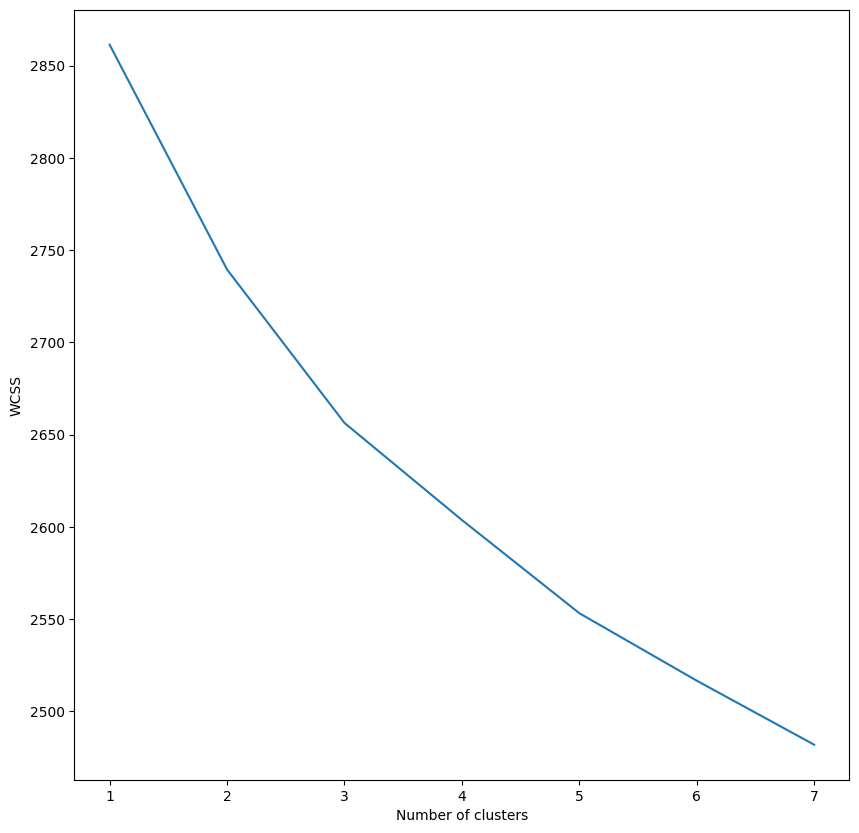

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# get sentence embeddings of topic one tweets

texts, embeddings = get_embeddings(df_topic_0)

wcss = []
for i in range(1, 8):
    model = KMeans(n_clusters=i, init="k-means++")
    model.fit(embeddings)
    wcss.append(model.inertia_)
plt.figure(figsize=(10, 10))
plt.plot(range(1, 8), wcss)
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [ ]:
pca = PCA(50)
data = pca.fit_transform(embeddings)

sentiment = df_topic_0.cohere.unique()

In [ ]:
import seaborn as sns

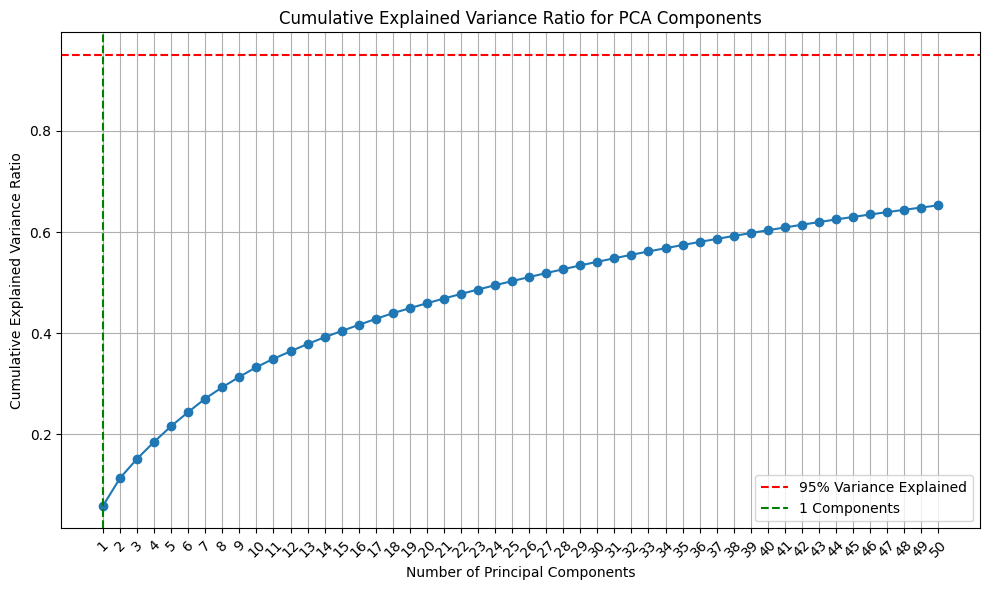

In [ ]:
# Calculate the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain 95% or more of the variance
n_components_95 = np.argmax(cumulative_explained_variance_ratio >= 0.95) + 1

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_explained_variance_ratio) + 1),
    cumulative_explained_variance_ratio,
    marker="o",
    linestyle="-",
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.title("Cumulative Explained Variance Ratio for PCA Components")
plt.xticks(range(1, len(cumulative_explained_variance_ratio) + 1), rotation=45)
plt.grid(True)

# Add a horizontal line at 95%
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Variance Explained")
plt.axvline(
    x=n_components_95, color="g", linestyle="--", label=f"{n_components_95} Components"
)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
negative_df = df_topic_0[df_topic_0.cohere == "negative"]
negative_df.reset_index(inplace=True)
negative_df.iloc[4].tweet

'1 in 7 Arizonans live in areas without the infrastructure for minimally acceptable broadband speeds. Our infrastructure framework would close the digital divide in rural and Tribal communities across Arizona. https://t.co/0TVaFRQYNb'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.utils import resample

In [ ]:
# label encoder
le = preprocessing.LabelEncoder()
labeler = le.fit(df_topic_0.cohere)
labels = labeler.transform(df_topic_0.cohere)

In [ ]:
labeler.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [ ]:
df_data = pd.DataFrame(data)
df_data["labels"] = labels

In [ ]:
# Separate the data by sentiment class
positive_sentiments = df_data[df_data["labels"] == 0]
negative_sentiments = df_data[df_data["labels"] == 1]
neutral_sentiments = df_data[df_data["labels"] == 2]

# Determine the number of samples to balance the dataset
num_samples_per_class = min(
    len(positive_sentiments), len(negative_sentiments), len(neutral_sentiments)
)

# Randomly sample an equal number of samples from each class
positive_samples = resample(
    positive_sentiments, n_samples=num_samples_per_class, random_state=42
)
negative_samples = resample(
    negative_sentiments, n_samples=num_samples_per_class, random_state=42
)
neutral_samples = resample(
    neutral_sentiments, n_samples=num_samples_per_class, random_state=42
)

# Combine the balanced samples into a new DataFrame
balanced_df = pd.concat([positive_samples, negative_samples, neutral_samples])

In [ ]:
X = balanced_df.drop("labels", axis=1)
y = balanced_df["labels"]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1_score_ = f1_score(y_test, y_pred, average="macro")
confusion_matrix_ = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score_)
print("\nConfusion matrix")
print(confusion_matrix_)

Accuracy: 0.8604651162790697
Precision: 0.8641975308641975
Recall: 0.852858627858628
F1-Score: 0.8544502791260126

Confusion matrix
[[47  2  3]
 [ 3 37  0]
 [ 4  6 27]]


In [ ]:
!pip install black[jupyter] --quiet

!black /content/drive/MyDrive/Colab\ Notebooks/data_collection.ipynb